In [2]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from google.colab import drive
import glob
import os
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive/')


Mounted at /content/drive/


In [101]:
#@title Select dataset

cell_line = 'both' #@param['HT29', 'Hs766T', 'both']
evaluate = 'dapi' #@param['dapi','pi']


def import_images(im, md, path, evaluate, reset = True):
  for img in os.listdir(path+'bf'):
    im.append(1-cv2.resize(cv2.imread(f"{path}bf/{img}")/255.0, (256,256)))
    md.append(cv2.resize(cv2.imread(f"{path}{evaluate}_m/{img}", cv2.IMREAD_GRAYSCALE)/255.0, (256,256)))

bf_images = []
dye_images = []

if cell_line == 'HT29':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'Hs766T':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'both':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)

In [103]:
#@title Train-test split

X_train, X_test, y_train, y_test = train_test_split(bf_images, np.round(dye_images), test_size=0.33, random_state=40)

# Change format so that keras is happy (everything as np arrays, add an empty axis to y)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_train = y_train[..., np.newaxis]
y_test = np.asarray(y_test)
y_test = y_test[..., np.newaxis]

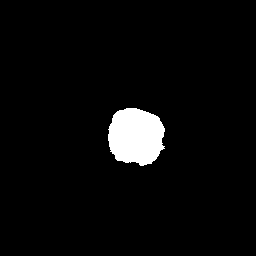

In [104]:
#@title Quick check 1: open one image of our Y train set:
cv2_imshow((y_train[10])*255)

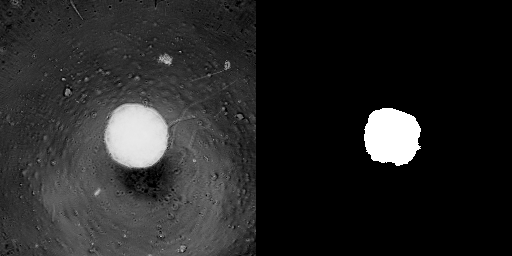

In [105]:
#@title Quick check 2: open one pair of images of our train set:
i = 10 #@param {type: "integer"}
cv2_imshow(np.concatenate(((X_train[i]*255).astype(np.uint8),cv2.cvtColor((y_train[i]*255).astype(np.uint8),cv2.COLOR_GRAY2RGB)), axis = 1))

In [106]:
y_train.shape

(65, 256, 256, 1)

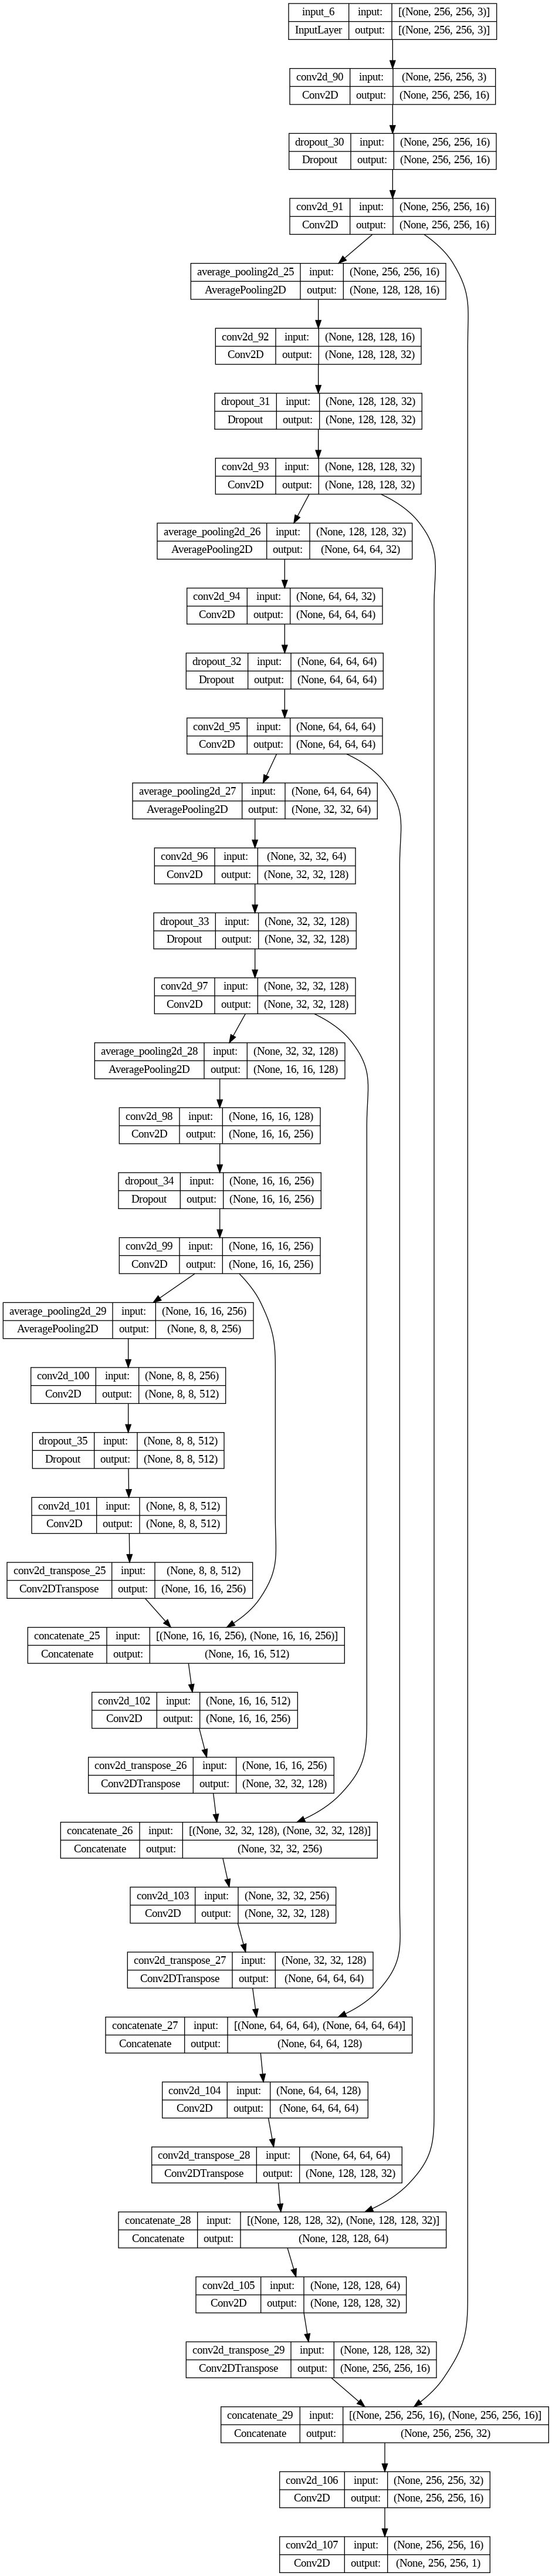

In [107]:
#@title Neural Network Setup

inputs = tf.keras.layers.Input(shape=(256, 256 ,3))

kernel_size = 3 # default = 3
pool_size = 2 # default = 2
#dropout = 0.3
#n_filters = # def: [16, 32, 64, 128, 256, 128, 64, 32, 16]

def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    return c6, c5, c4, c3, c2, c1

num_classes = 1
def decoder(c6, c5, c4, c3, c2, c1):

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c5])
    c7 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = tf.keras.layers.Add()([u7, c7])

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c4])
    c8 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = tf.keras.layers.Add()([u8, c8])

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c3])
    c9 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = tf.keras.layers.Add()([u9, c9])

    u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = tf.keras.layers.concatenate([u10, c2])
    c10 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    #c10 = tf.keras.layers.Add()([u10, c10])

    u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = tf.keras.layers.concatenate([u11, c1])
    c11 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    #c11 = tf.keras.layers.Add()([u11, c11])

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c11)
    return outputs

c6, c5, c4, c3, c2, c1 = encoder(inputs)
outputs = decoder(c6, c5, c4, c3, c2, c1)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

#model.summary()
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [108]:
#@title Train Neural Network

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["binary_accuracy"])

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=70, callbacks=callbacks)


Epoch 1/70
65/65 [==============================] - 11s 28ms/step - loss: 0.4442 - binary_accuracy: 0.8837 - val_loss: 0.2332 - val_binary_accuracy: 0.9383
Epoch 2/70
65/65 [==============================] - 1s 20ms/step - loss: 0.2277 - binary_accuracy: 0.8952 - val_loss: 0.1573 - val_binary_accuracy: 0.9462
Epoch 3/70
65/65 [==============================] - 1s 20ms/step - loss: 0.1605 - binary_accuracy: 0.9324 - val_loss: 0.1502 - val_binary_accuracy: 0.9353
Epoch 4/70
65/65 [==============================] - 1s 20ms/step - loss: 0.1366 - binary_accuracy: 0.9387 - val_loss: 0.1239 - val_binary_accuracy: 0.9479
Epoch 5/70
65/65 [==============================] - 1s 20ms/step - loss: 0.1303 - binary_accuracy: 0.9454 - val_loss: 0.1224 - val_binary_accuracy: 0.9513
Epoch 6/70
65/65 [==============================] - 1s 21ms/step - loss: 0.1358 - binary_accuracy: 0.9395 - val_loss: 0.1367 - val_binary_accuracy: 0.9367
Epoch 7/70
65/65 [==============================] - 1s 20ms/step - lo

In [111]:
#@title Save model
#model.save(f"unet_{cell_line}_{evaluate}.keras")
model.save(f"unet_{cell_line}_{evaluate}.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


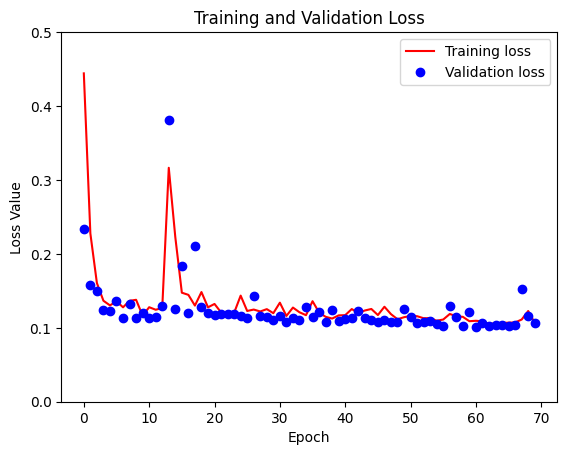

In [109]:
#@title Training / Validation Loss curve

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

2/2 [==============================] - 0s 78ms/step


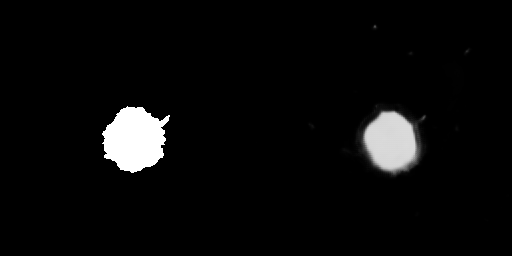

0.7487277353689568


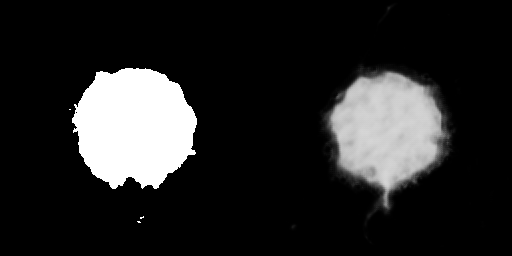

0.7987632053594435


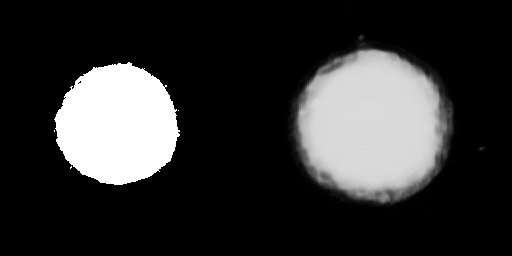

0.7201940419180297


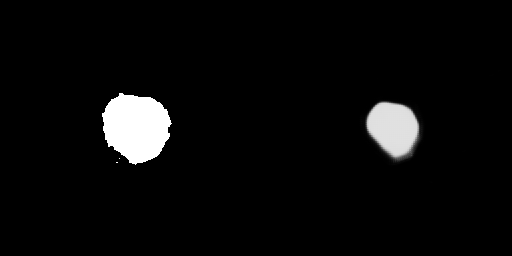

0.5787586206896552


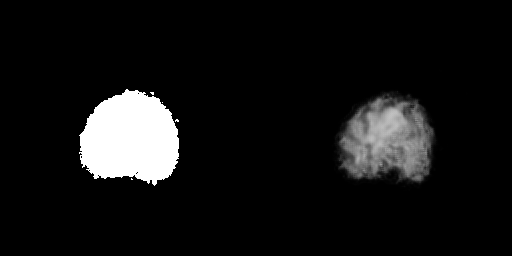

0.36106880797452584


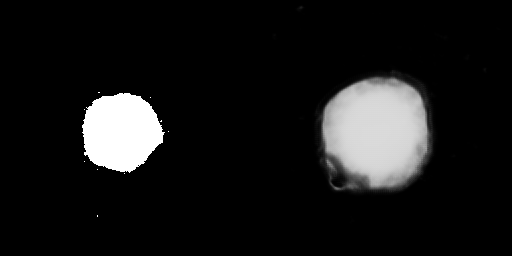

0.5654323827046918


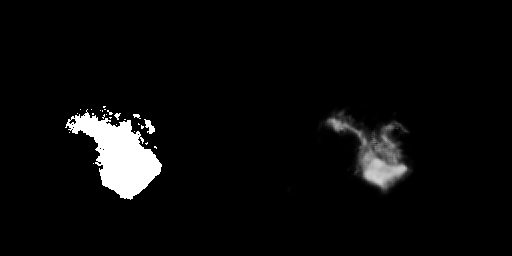

0.22058823529411764


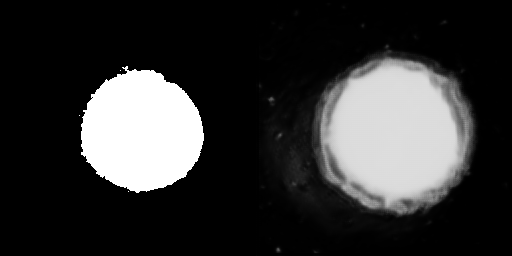

0.72323384018522


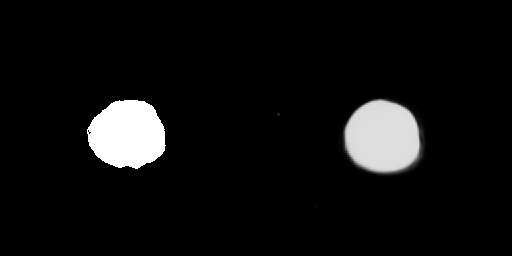

0.8895555555555555


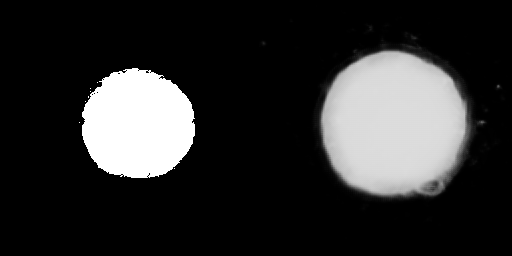

0.5950579621720561


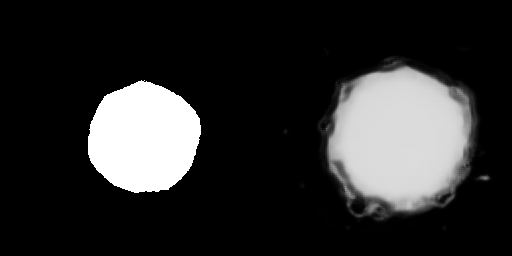

0.6573379301020753


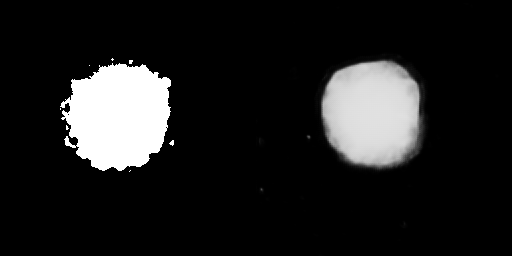

0.8425053533190578


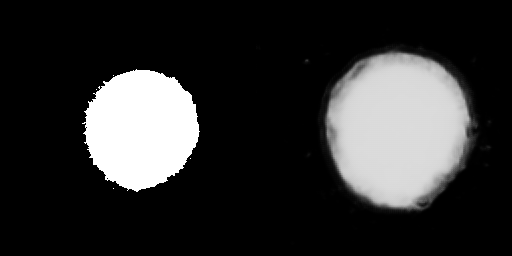

0.6437526497486524


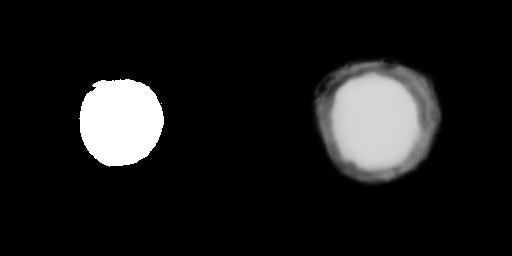

0.7842273819055244


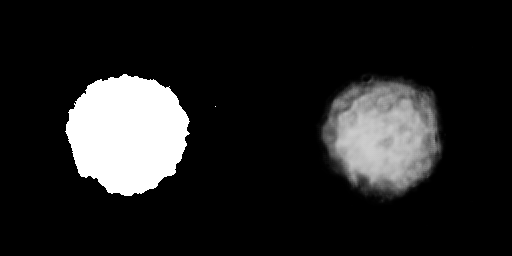

0.6182318480383454


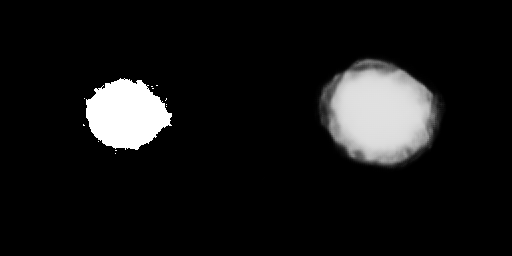

0.5785798972467395


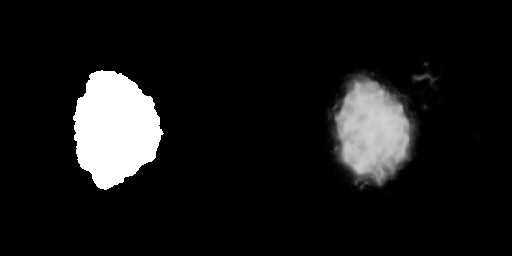

0.6612945492662474


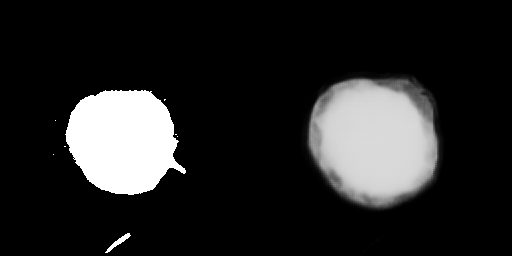

0.7706283118849356


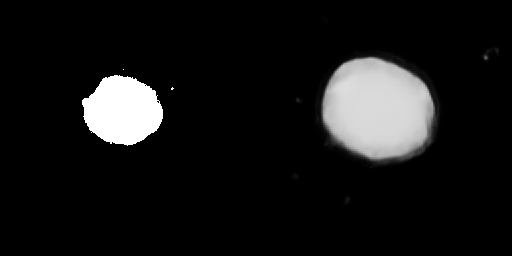

0.48997668997668997


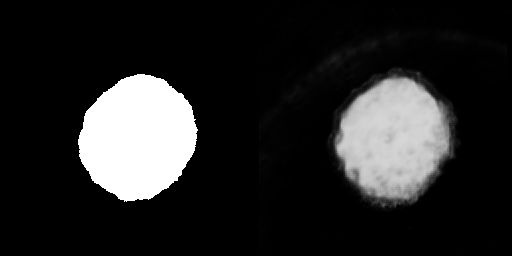

0.86800497424054


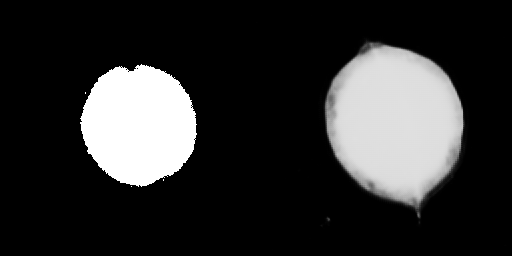

0.6718352663896298


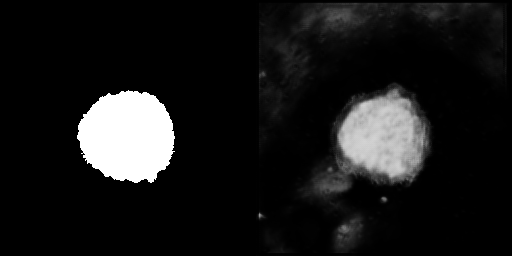

0.7238505747126437


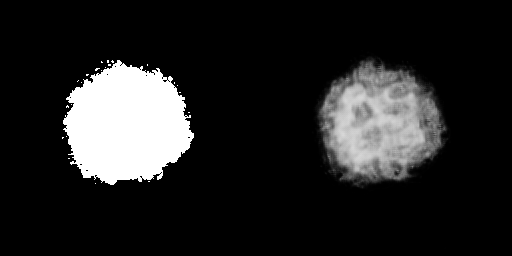

0.6338974402585253


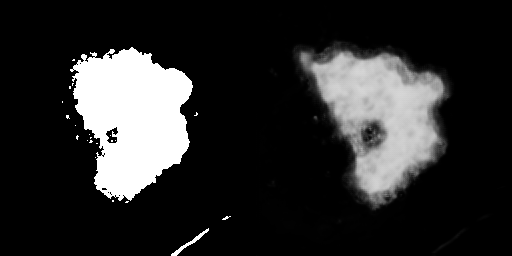

0.7513840702738613


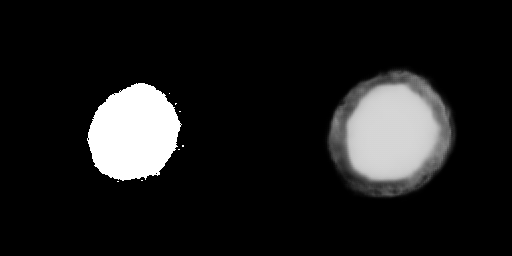

0.888332234673698


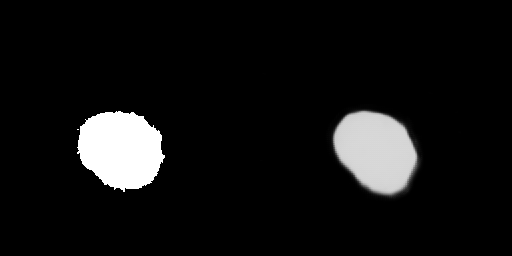

0.8882763689819919


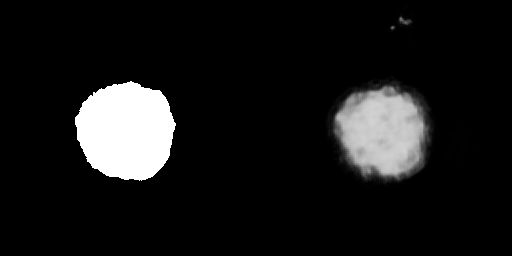

0.730784288137805


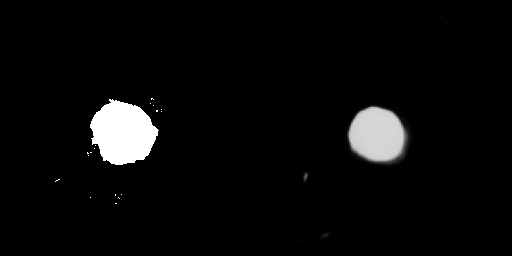

0.7255685310387215


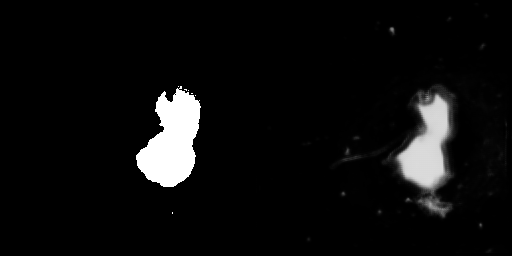

0.6621127104171749


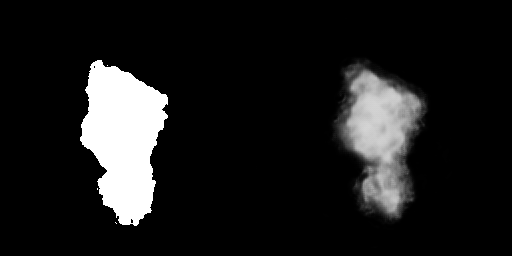

0.5879067769305123


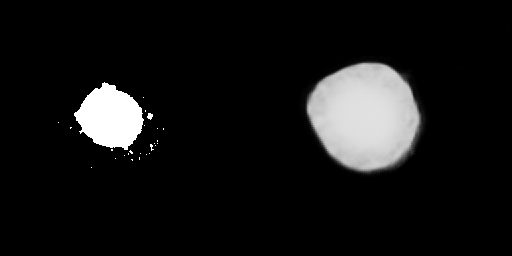

0.3549348642084345


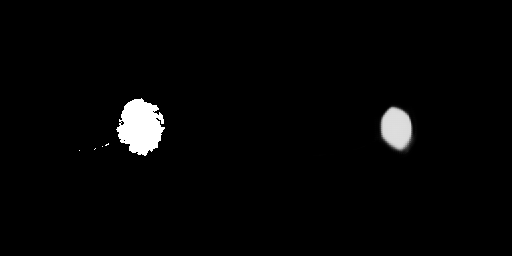

0.5156576200417536


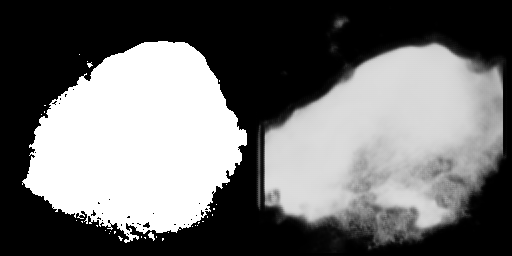

0.8045305931807567
0.6683330700665627


In [110]:
#@title Generate predictions and validate with Jaccard similarity


y_pred = model.predict(np.asarray(X_test))

succ = []
for i in range(len(y_pred)):
  cv2_imshow(np.concatenate((y_test[i], y_pred[i]), axis = 1)*255)
  jacc = np.logical_and(y_test[i], y_pred[i]>0.5).sum()/np.logical_or(y_test[i], y_pred[i]>0.5).sum()

  succ.append(jacc)
  print(jacc)


print(np.average(succ))